# Smart Analysis

API :: [opstool.anlys.SmartAnalyze](https://opstool.readthedocs.io/en/latest/src/api/_autosummary/opstool.anlys.SmartAnalyze.html#opstool.anlys.SmartAnalyze)

In [1]:
import openseespy.opensees as ops
import opstool as opst

## Reinforced Concrete Frame Pushover Analysis

### Moddling

In [2]:
def model():
    ops.wipe()
    ops.model("basic", "-ndm", 3, "-ndf", 6)
    width = 360.0
    height = 144.0
    ops.node(1, 0.0, 0.0, 0.0)
    ops.node(2, width, 0.0, 0.0)
    ops.node(3, 0.0, 0.0, height)
    ops.node(4, width, 0.0, height)
    ops.fix(1, 1, 1, 1, 1, 1, 1)
    ops.fix(2, 1, 1, 1, 1, 1, 1)

    ops.uniaxialMaterial("Concrete01", 1, -6.0, -0.004, -5.0, -0.014)
    ops.uniaxialMaterial("Concrete01", 2, -5.0, -0.002, 0.0, -0.006)

    fy = 60.0
    E = 30000.0
    ops.uniaxialMaterial("Steel01", 3, fy, E, 0.01)

    # Define cross-section for nonlinear columns
    # ------------------------------------------
    colWidth = 15
    colDepth = 24
    cover = 1.5
    As = 0.60  # area of no. 7 bars
    # some variables derived from the parameters
    y1 = colDepth / 2.0
    z1 = colWidth / 2.0

    ops.section("Fiber", 1, "-GJ", 1000000)
    ops.patch("rect", 1, 10, 10, cover - y1, cover - z1, y1 - cover, z1 - cover)
    # Create the concrete cover fibers (top, bottom, left, right)
    ops.patch("rect", 2, 11, 1, -y1, z1 - cover, y1, z1)
    ops.patch("rect", 2, 11, 1, -y1, -z1, y1, cover - z1)
    ops.patch("rect", 2, 1, 10, -y1, cover - z1, cover - y1, z1 - cover)
    ops.patch("rect", 2, 1, 10, y1 - cover, cover - z1, y1, z1 - cover)
    # Create the reinforcing fibers (left, middle, right)
    ops.layer("straight", 3, 5, As, y1 - cover, z1 - cover, y1 - cover, cover - z1)
    ops.layer("straight", 3, 2, As, 0.0, z1 - cover, 0.0, cover - z1)
    ops.layer("straight", 3, 5, As, cover - y1, z1 - cover, cover - y1, cover - z1)

    # Define column elements
    # ----------------------
    ops.geomTransf("PDelta", 1, -1, 0, 0)
    # Number of integration points along length of element
    np = 5
    # Lobatto integratoin
    ops.beamIntegration("Lobatto", 1, 1, np)
    eleType = "forceBeamColumn"
    ops.element(eleType, 1, 1, 3, 1, 1)
    ops.element(eleType, 2, 2, 4, 1, 1)

    # Define beam elment
    # -----------------------------
    ops.geomTransf("Linear", 2, 0.0, 0.0, 1.0)
    ops.element("elasticBeamColumn", 3, 3, 4, 360.0, 4030.0, 2015.0, 10000, 8640.0, 8640.0, 2)

OPSTOOL ::  Model data has been saved to _OPSTOOL_ODB/ModelData-None.nc!

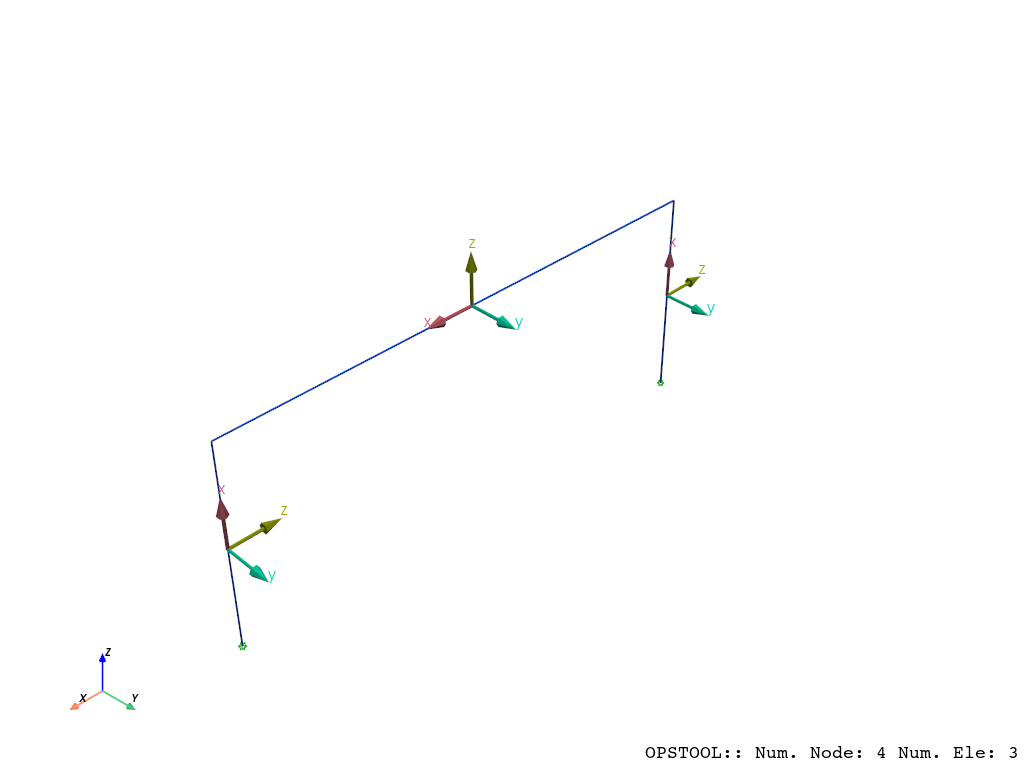

In [3]:
model()
opst.vis.pyvista.set_plot_props(notebook=True)  # you should not use
fig = opst.vis.pyvista.plot_model(show_local_axes=True)
fig.show(jupyter_backend="jupyterlab")
# fig.show()

### Gravity analysis

In [4]:
def gravity_analysis():
    #  a parameter for the axial load
    P = 180.0  # 10% of axial capacity of columns

    # Create a Plain load pattern with a Linear TimeSeries
    ops.timeSeries("Linear", 1)
    ops.pattern("Plain", 1, 1)

    # Create nodal loads at nodes 3 & 4
    #    nd  FX,  FY, MZ
    ops.load(3, 0.0, 0.0, -P, 0.0, 0.0, 0.0)
    ops.load(4, 0.0, 0.0, -P, 0.0, 0.0, 0.0)

    # Start of analysis generation
    # ------------------------------
    ops.system("BandGeneral")
    ops.constraints("Transformation")
    ops.numberer("RCM")
    ops.test("NormDispIncr", 1.0e-12, 10, 3)
    ops.algorithm("Newton")
    ops.integrator("LoadControl", 0.1)
    ops.analysis("Static")
    ops.analyze(10)

### Pushover analysis

In [5]:
def pushover_load():
    ops.loadConst("-time", 0.0)
    # Define lateral loads
    # --------------------
    # Set some parameters
    H = 10.0  # Reference lateral load
    # Set lateral load pattern with a Linear TimeSeries
    ops.pattern("Plain", 2, 1)
    ops.load(3, H, 0.0, 0.0, 0.0, 0.0, 0.0)
    ops.load(4, H, 0.0, 0.0, 0.0, 0.0, 0.0)

### Smart Analysis

#### No fixed number of analyses

In [6]:
# Set some parameters
dU = 0.1  # Displacement increment
maxU = 45.0  # Max displacement
ok = 0
currentDisp = 0

model()
gravity_analysis()
pushover_load()

If ``tryAddTestTimes`` is turned on, it will first try to increase the number of test; 

if ``tryAlterAlgoTypes`` is turned on, it will continue to try to change the iterative algorithm specified by the user; 

Then, if it does not converge, it will try to automatically split the step size until the specified minimum step size ``minStep`` is reached. 

If it still does not converge, the analysis is considered to have failed.

We can see that opensees throws out non-convergence information, but converges successfully when the number of iterations increases to 50.

In [7]:
ODB = opst.post.CreateODB(odb_tag=1)  # Create an ODB object to store results

analysis = opst.anlys.SmartAnalyze(
    "Static",
    tryAddTestTimes=True,  # add test times to the analysis
    testIterTimesMore=[50, 100],
    tryAlterAlgoTypes=True,  # try different algorithms
    algoTypes=[40, 10, 20, 30],  # algorithm types to try
    minStep=1e-6,  # minimum step size for substepping
    debugMode=True,  # False for progress bar, True for debug info
    printPer=100,  # print every 100 steps
)

while ok == 0 and currentDisp < maxU:
    #  Perform the analysis one step at a time
    analysis.StaticAnalyze(node=3, dof=1, seg=dU)

    ODB.fetch_response_step()  # Fetch the response for the current step

    currentDisp = ops.nodeDisp(3, 1)
ODB.save_response()

print("🎉 Analysis Completed Successfully 🎉")

>>> ⚙ SmartAnalyze: Setting algorithm to  KrylovNewton ...

>>> ⌛ SmartAnalyze: progress 100 steps. Time consumption: 0.427 s.

>>> ⌛ SmartAnalyze: progress 200 steps. Time consumption: 0.760 s.

after: 10 iterations
 current EnergyIncr: 1.84355e-05 (max: 1e-10) 	Norm deltaX: 0.000384464, Norm deltaR: 0.194756
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 2.89482
OpenSees > analyze failed, returned: -3 error flag


>>> ⚙ SmartAnalyze: Adding test times to 50.

>>> ⌛ SmartAnalyze: progress 300 steps. Time consumption: 1.105 s.

>>> ⌛ SmartAnalyze: progress 400 steps. Time consumption: 1.414 s.

after: 10 iterations
 current EnergyIncr: 2.70125e-05 (max: 1e-10) 	Norm deltaX: 0.000819596, Norm deltaR: 0.253889
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 1.64367
OpenSees > analyze failed, returned: -3 error flag


>>> ⚙ SmartAnalyze: Adding test times to 50.

OPSTOOL ::  All responses data with _odb_tag = 1 saved in _OPSTOOL_ODB/RespStepData-1.nc!

🎉 Analysis Completed Successfully 🎉


#### Analysis of the fixed number of steps

In [8]:
# Set some parameters
dU = 0.1  # Displacement increment
maxU = 45.0  # Max displacement

model()
gravity_analysis()
pushover_load()

In [9]:
ODB = opst.post.CreateODB(odb_tag=2)  # Create ODB object

analysis = opst.anlys.SmartAnalyze(
    "Static",
    tryAddTestTimes=True,  # add test times to the analysis
    testIterTimesMore=[50, 100],
    tryAlterAlgoTypes=True,  # try different algorithms
    algoTypes=[40, 10, 20, 30],  # algorithm types to try
    minStep=1e-6,  # minimum step size for substepping
    debugMode=False,  # False for progress bar, True for debug info
)
segs = analysis.static_split([maxU], dU)

for seg in segs:
    analysis.StaticAnalyze(node=3, dof=1, seg=seg)
    ODB.fetch_response_step()  # fetch response for the current step
ODB.save_response()  # save response to ODB

Output()

🎉 SmartAnalyze: Successfully finished! Time consumption: 2.928 s. 🎉

OPSTOOL ::  All responses data with _odb_tag = 2 saved in _OPSTOOL_ODB/RespStepData-2.nc!

![image22.png](https://s2.loli.net/2025/04/19/EsjSAZlFpwYDe4L.png)

### Post-processing

In [10]:
node_resp = opst.post.get_nodal_responses(odb_tag=1)
print(node_resp)

OPSTOOL ::  Loading all response data from _OPSTOOL_ODB/RespStepData-1.nc ...

<xarray.Dataset> Size: 538kB
Dimensions:             (time: 451, nodeTags: 4, DOFs: 6)
Coordinates:
  * nodeTags            (nodeTags) int32 16B 1 2 3 4
  * DOFs                (DOFs) <U2 48B 'UX' 'UY' 'UZ' 'RX' 'RY' 'RZ'
  * time                (time) float64 4kB 0.0 0.6715 1.179 ... 1.536 1.519
Data variables:
    disp                (time, nodeTags, DOFs) float64 87kB 0.0 ... 6.499e-15
    vel                 (time, nodeTags, DOFs) float64 87kB 0.0 0.0 ... 0.0 0.0
    accel               (time, nodeTags, DOFs) float64 87kB 0.0 0.0 ... 0.0 0.0
    reaction            (time, nodeTags, DOFs) float64 87kB 1.08e-15 ... -4.9...
    reactionIncInertia  (time, nodeTags, DOFs) float64 87kB 1.08e-15 ... -4.9...
    rayleighForces      (time, nodeTags, DOFs) float64 87kB 0.0 0.0 ... 0.0 0.0
    pressure            (time, nodeTags) float64 14kB 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    UX:       Displacement in X direction
    UY:       Displacement in Y direction
    UZ:       Displacement in Z 

In [11]:
node3disp = node_resp["disp"].sel(nodeTags=3, DOFs="UX")
reaction = node_resp["reaction"].sel(DOFs="UX").sum(dim="nodeTags")

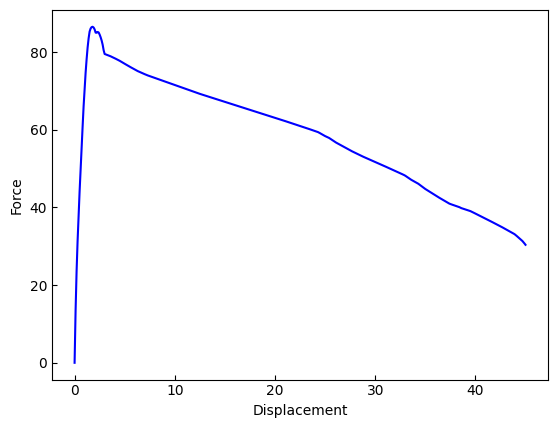

In [12]:
import matplotlib.pyplot as plt

plt.plot(node3disp, -reaction, c="b")
plt.xlabel("Displacement")
plt.ylabel("Force")
plt.show()